#AttnGAN

In [1]:
!nvidia-smi

Tue Oct  6 13:35:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
!rm -r /content/sample_data/

In [3]:
os.chdir('/content')
!rm -r AttnGAN
!git clone https://github.com/taoxugit/AttnGAN.git

rm: cannot remove 'AttnGAN': No such file or directory
Cloning into 'AttnGAN'...
remote: Enumerating objects: 291, done.
remote: Total 291 (delta 0), reused 0 (delta 0), pack-reused 291
Receiving objects: 100% (291/291), 36.76 MiB | 4.36 MiB/s, done.
Resolving deltas: 100% (167/167), done.


In [4]:
os.chdir('/content/AttnGAN/data/')
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1O_LtUP9sch09QH3s_EBAgLEctBQ5JBSJ' -O birds.zip
!cp '/content/drive/My Drive/birds/birds.zip' '/content/AttnGAN/data/'
!unzip -q birds.zip
!rm birds.zip
!rm -r __MACOSX/

cp: cannot stat '/content/drive/My Drive/birds/birds.zip': No such file or directory
unzip:  cannot find or open birds.zip, birds.zip.zip or birds.zip.ZIP.
rm: cannot remove 'birds.zip': No such file or directory
rm: cannot remove '__MACOSX/': No such file or directory


#FID


In [10]:
pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 101kB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [11]:
os.chdir('/content')
!rm -r /content/FID/
!git clone https://github.com/ammarnasr/FID.git
!mv /content/FID/img_data.py /content/
!mv /content/FID/inception.py /content/

Cloning into 'FID'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17 (delta 5), reused 10 (delta 1), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [21]:
!pip3 install torch

In [20]:
!pip3 install torchvision

     |████████████████████████████████| 5.9MB 6.4MB/s 


In [22]:
import torch

ValueError: ignored

In [14]:
#!/usr/bin/env python3
"""Calculates the Frechet Inception Distance (FID) to evalulate GANs
The FID metric calculates the distance between two distributions of images.
Typically, we have summary statistics (mean & covariance matrix) of one
of these distributions, while the 2nd distribution is given by a GAN.
When run as a stand-alone program, it compares the distribution of
images that are stored as PNG/JPEG at a specified location with a
distribution given by summary statistics (in pickle format).
The FID is calculated by assuming that X_1 and X_2 are the activations of
the pool_3 layer of the inception net for generated samples and real world
samples respectivly.
See --help to see further details.
Code apapted from https://github.com/bioinf-jku/TTUR to use PyTorch instead
of Tensorflow
Copyright 2018 Institute of Bioinformatics, JKU Linz
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
   http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""
import os
import pathlib
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

import torch
import numpy as np
from scipy.misc import imread
from scipy import linalg
from torch.autograd import Variable
from torch.nn.functional import adaptive_avg_pool2d
import torchvision.transforms as transforms
import torch.utils.data
from PIL import Image
from torch.utils import data
import img_data as img_data
from inception import InceptionV3

# parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
# #parser.add_argument('path', type=str, nargs=2,
# #                    help=('Path to the generated images or '
# #                          'to .npz statistic files'))
# parser.add_argument('--batch-size', type=int, default=64,
#                     help='Batch size to use')
# parser.add_argument('--dims', type=int, default=2048,
#                     choices=list(InceptionV3.BLOCK_INDEX_BY_DIM),
#                     help=('Dimensionality of Inception features to use. '
#                           'By default, uses pool3 features'))
# parser.add_argument('-c', '--gpu', default='', type=str,
#                     help='GPU to use (leave blank for CPU only)')
# parser.add_argument('--path1', type=str, default=64)
# parser.add_argument('--path2', type=str, default=64)

def get_activations(images, model, batch_size=64, dims=2048, cuda=False, verbose=True):
    """Calculates the activations of the pool_3 layer for all images.
    Params:
    -- images      : Numpy array of dimension (n_images, 3, hi, wi). The values
                     must lie between 0 and 1.
    -- model       : Instance of inception model
    -- batch_size  : the images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size depends
                     on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the number
                     of calculated batches is reported.
    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()

    #d0 = images.shape[0]

    d0 = images.__len__() * batch_size
    if batch_size > d0:
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = d0

    n_batches = d0 // batch_size
    n_used_imgs = n_batches * batch_size

    pred_arr = np.empty((n_used_imgs, dims))
    #for i in range(n_batches):
    for i, batch in enumerate(images):
        #batch = batch[0]
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches), end='', flush=True)
        #import ipdb
        #ipdb.set_trace()
        start = i * batch_size
        end = start + batch_size

        #batch = torch.from_numpy(images[start:end]).type(torch.FloatTensor)
        #batch = Variable(batch, volatile=True)

        if cuda:
            batch = batch.cuda()
        #print('The Model: ')
        #print(model)
        #print('The Batch: ')
        #print(batch.size())torch.Size([50, 3, 299, 299]) 
        pred = model(batch)[0]
        #print('The pred: ')
        #print(pred.size())torch.Size([50, 2048, 1, 1])

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.shape[2] != 1 or pred.shape[3] != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred_arr[start:end] = pred.cpu().data.numpy().reshape(batch_size, -1)
        #print('pred_arr')
        #print(pred_arr.size) 24064000

    if verbose:
        print(' done')

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an 
               representive data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an 
               representive data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics(images, model, batch_size=64,
                                    dims=2048, cuda=False, verbose=True):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, 3, hi, wi). The values
                     must lie between 0 and 1.
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the
                     number of calculated batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    print('----------------------------------------------------------------')
    act = get_activations(images, model, batch_size, dims, cuda, verbose= True)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    #print('mu: ', mu )
    #print('sigma: ', sigma )
    return mu, sigma

def _compute_statistics_of_path(path, model, batch_size, dims, cuda):
    if path.endswith('.npz'):
        f = np.load(path)
        m, s = f['mu'][:], f['sigma'][:]
        f.close()

    else:
        dataset = img_data.Dataset(path, transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
        ]))
        print(dataset.__len__())
        dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=8)
        m, s = calculate_activation_statistics(dataloader, model, batch_size, dims, cuda)
    return m, s

def calculate_fid_given_paths(paths, batch_size, cuda, dims):
    """Calculates the FID of two paths"""
    for p in paths:
        if not os.path.exists(p):
            raise RuntimeError('Invalid path: %s' % p)

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx])
    #model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)

    if cuda:
        model.cuda()

    m1, s1 = _compute_statistics_of_path(paths[0], model, batch_size, dims, cuda)
    m2, s2 = _compute_statistics_of_path(paths[1], model, batch_size, dims, cuda)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)
    return fid_value

ValueError: ignored

In [13]:
import os
import pickle
__name__ = '__main__'
if __name__ == '__main__':
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    paths = ["",""]


    imagePathList = [
                    '/content/AttnGAN/models/netG_epoch_0/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_10/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_20/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_30/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_40/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_50/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_60/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_70/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_80/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_90/valid/single/',

                    '/content/AttnGAN/models/netG_epoch_100/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_110/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_120/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_130/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_140/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_150/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_160/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_170/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_180/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_190/valid/single/',
                    
                    '/content/AttnGAN/models/netG_epoch_200/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_210/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_220/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_230/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_240/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_250/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_260/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_270/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_280/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_290/valid/single/',
                    
                    '/content/AttnGAN/models/netG_epoch_300/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_310/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_320/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_330/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_340/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_350/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_360/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_370/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_380/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_390/valid/single/',
                    
                    '/content/AttnGAN/models/netG_epoch_400/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_410/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_420/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_430/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_440/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_450/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_460/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_470/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_480/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_490/valid/single/',
                    
                    '/content/AttnGAN/models/netG_epoch_500/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_510/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_520/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_530/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_540/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_550/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_560/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_570/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_580/valid/single/',
                    '/content/AttnGAN/models/netG_epoch_590/valid/single/',
                    
                    '/content/AttnGAN/models/netG_epoch_600/valid/single/'
                ]





    fid_scores = []
    for i in imagePathList:
      print(i)
      paths[0] = '/content/AttnGAN/data/birds/CUB_200_2011/images/'
      paths[1] = i
      fid_value = calculate_fid_given_paths(paths, 50 ,'0',2048) #inputs => paths, batch_size, cuda, dims
      print('FID: ', fid_value)
      fid_scores.append(fid_value)

    with open('/content/fid_scores.pkl', 'wb') as f:
      pickle.dump(fid_scores, f)

/content/AttnGAN/models/netG_epoch_0/valid/single/


NameError: ignored

#Save FID Scores to Drive

In [ ]:
with open('/content/fid_scores.pkl', 'rb') as f:
    fidd_scores = pickle.load(f)

!cp /content/fid_scores.pkl '/content/drive/My Drive/scores'


print(fidd_scores)

In [ ]:
with open('/content/wfid_scores.pkl', 'rb') as f:
    wfid_scores = pickle.load(f)


In [ ]:
with open('/content/sfid_scores.pkl', 'rb') as f:
    sfid_scores = pickle.load(f)


In [ ]:
epochs = []
for i,j in enumerate(sfid_scores):
      epochs.append(i*10)

print(epochs)

#Plot FID Scores

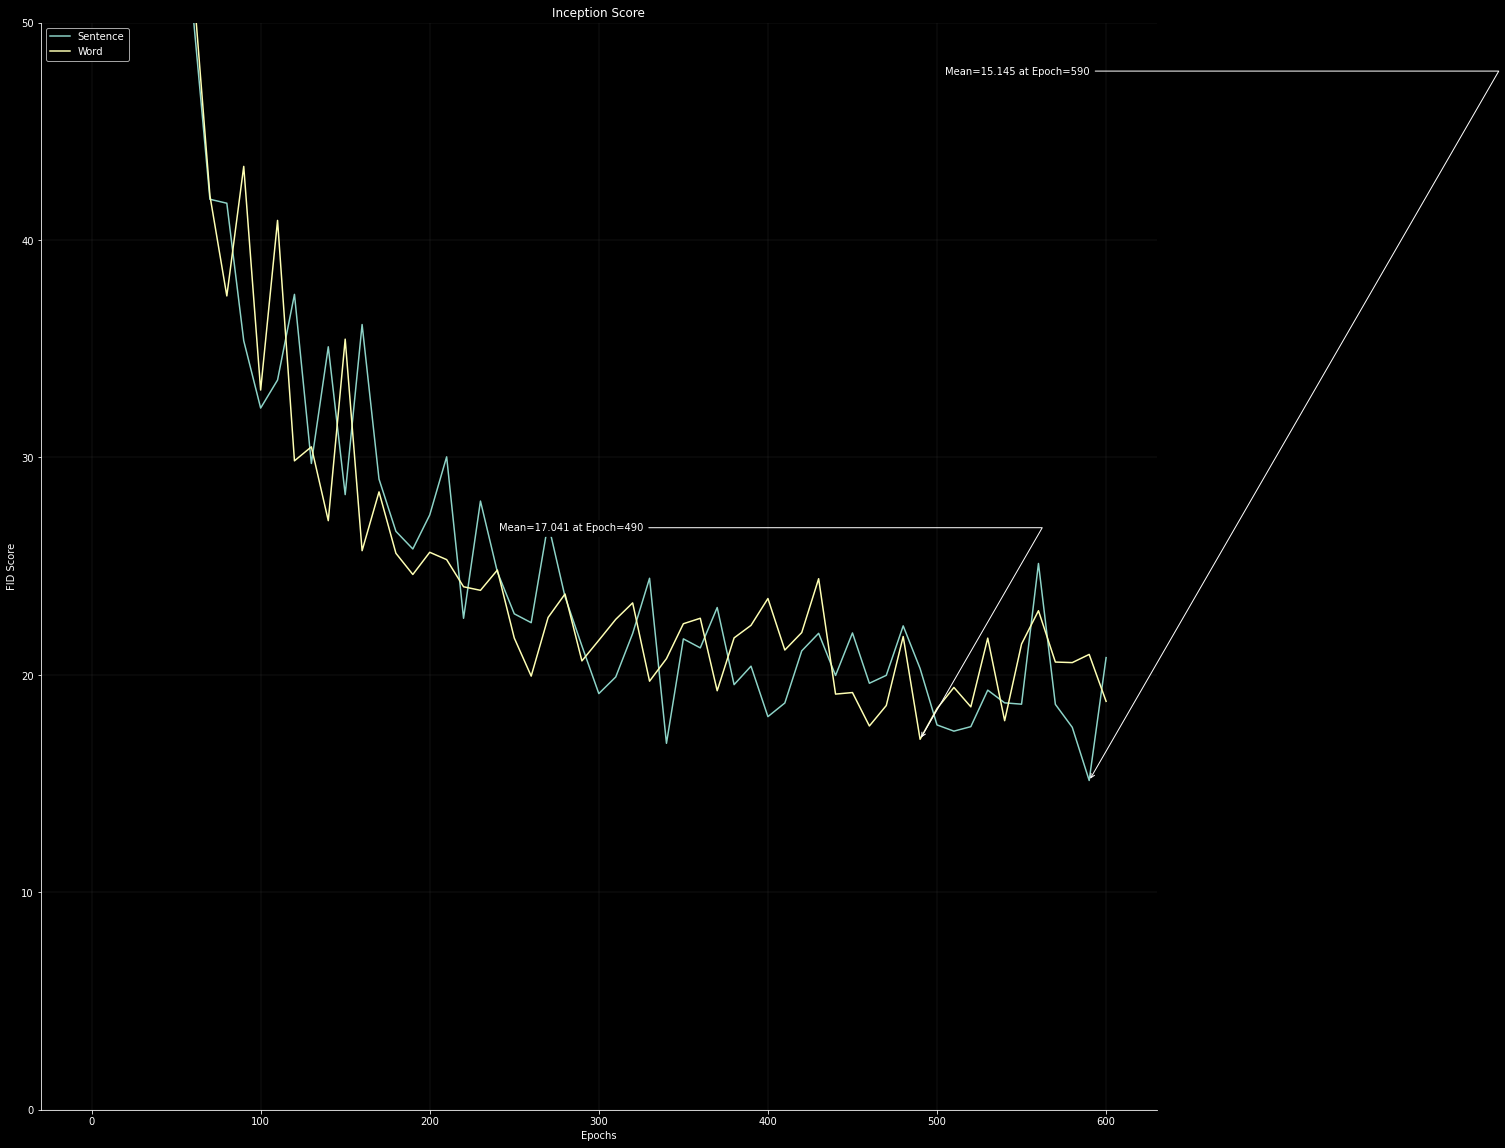

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('dark_background')

y = np.array(sfid_scores)
y2 = np.array(wfid_scores)
x = np.array(epochs)


fig, ax = plt.subplots(figsize=(20,20))
ax.plot(x,y, label = "Sentence")
ax.plot(x,y2, label = "Word")

def annot_max(x,y,left = 0.94, top = 0.96, ax=None):
    xmax = x[np.argmin(y)]
    ymax = y.min()
    text= "Mean={:.3f} at Epoch={:.0f}".format(ymax, xmax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="k", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(left,top), **kw)

ax.set_ylim(0,50)
annot_max(x,y)
annot_max(x,y2 , top =0.54, left=0.54)
plt.title("Inception Score")
plt.xlabel('Epochs')
plt.ylabel('FID Score') 
plt.legend(loc="upper left")


#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#adds major gridlines
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


plt.savefig('test.png')
plt.show()